Fundamentals of Machine Learning - WS 22
---

# PS2#04 - A Regression Pipeline
<div style="text-align: right;font-size: 0.8em">Last updated: 2022-11-12</div>

This notebook requires `numpy` and `matplotlib` to run. If the following cell raises an error, install them first.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 6) # Default figsize
np.random.seed(42)

The goal of this problem is to illustrate the influence of the choice of basis functions on the learned model. 
We will demonstrate the importance of _feature engineering_, and show how one can use noticeable patterns in the data to come up with relevant features.

We will illustrate this by learning multiple models for a synthetic dataset that describes solid friction. The model is taken from "Stick-Slip Friction Modeling in Tube Expansion", from Pervez et al.

## Introduction

### Data Generation

We assume that we have access to a physical testbed on which we can measure the friction force between two solids as a function of their relative velocity. This is represented by the function `create_dataset` below:

In [2]:
def friction_model(v, F_coulomb, F_s, stribeck_coef, viscous_coef, noise_std=None):
    F_b = F_coulomb + F_s
    v_coulomb = F_s / stribeck_coef
    
    strib = np.abs(v) < v_coulomb
    notstrib = np.logical_not(strib)
    
    force = np.zeros_like(v)
    force[strib] = np.sign(v[strib]) * (F_b - stribeck_coef * np.abs(v)[strib])
    force[notstrib] = np.sign(v[notstrib]) * F_coulomb + (v[notstrib] - np.sign(v[notstrib]) * v_coulomb) * viscous_coef
    
    if noise_std is not None:
        force += noise_std * np.random.normal(size=v.shape)
    
    return force

def create_dataset(N, v=None, noise=True):
    F_coulomb = 1.25
    F_s = .75
    stribeck_coef = 5
    viscous_coef = 1
    
    noise_std = 0.2 if noise else None
    
    if v is None:
        v = np.sort(np.random.uniform(-1, 1, N))
    F = friction_model(v, F_coulomb, F_s, stribeck_coef, viscous_coef, noise_std=noise_std)
    return v, F

For illustration purposes, we plot a large dataset sampled from this function, as well as the ground truth. In the rest of the notebook, we assume that we do not have access to these functions, but only to a limited data set.

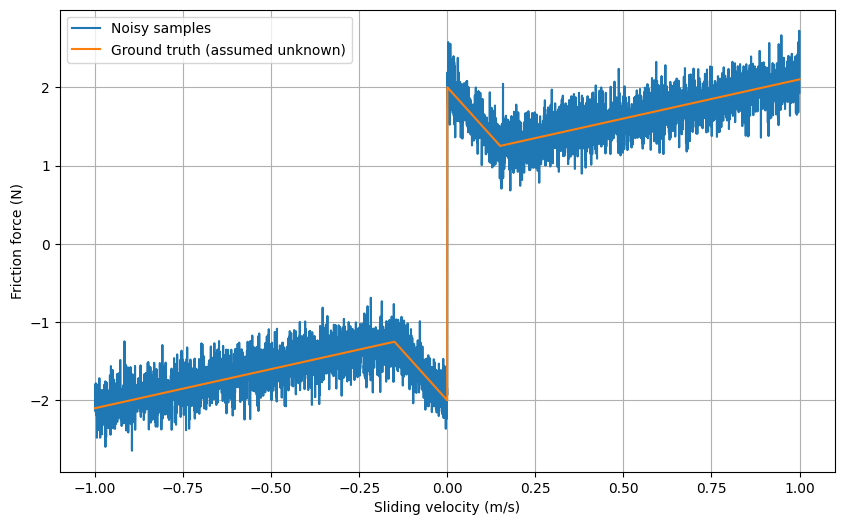

In [3]:
N_plot = 5000
X_plot = np.linspace(-1, 1, N_plot)
_, Y_plot = create_dataset(N_plot, v=X_plot)
_, ground_truth = create_dataset(N_plot, v=X_plot, noise=False)
plt.plot(X_plot, Y_plot, label='Noisy samples')
plt.plot(X_plot, ground_truth, label='Ground truth (assumed unknown)')
plt.xlabel('Sliding velocity (m/s)')
plt.ylabel('Friction force (N)')
plt.legend()
plt.grid(True)

We assume that all we have access to is the following dataset with $N = 1000$ points:

In [4]:
N = 1000
X_raw, Y_raw = create_dataset(N)

print(f'X:\nShape: {X_raw.shape}\nSample: {X_raw[:5]}\nY:\nShape: {Y_raw.shape}\nSample: {Y_raw[:5]}')

X:
Shape: (1000,)
Sample: [-0.99951799 -0.99919691 -0.99714331 -0.99268738 -0.99233942]
Y:
Shape: (1000,)
Sample: [-2.00805313 -1.67955262 -2.12475978 -1.97446015 -2.11373371]


### Data Preparation

We need to split the dataset `X_raw, Y_raw` into three sub parts: training, validation, and testing.
#### Question 1

Fill the function ``split``, that takes as input two arrays, `X` and `Y`, and a proportion `prop`, and splits the arrays in two.
The function also accepts an optional parameter `shuffle`: if shuffle is `True`, it should shuffle `X` and `Y` **consistently** before splitting.

**Careful**: we need to make sure that the data is correctly shuffled before splitting!

In [8]:
def split(X:np.ndarray, Y:np.ndarray, prop:float, shuffle:bool=True) -> tuple:
    """ Splits both `X` and `Y` in two arrays of size determined by `prop`.
    If X is split into X1 and X2, then X1 has ceil(prop * X.shape[0]) rows, and X2 has the rest.
    If `shuffle` is True, shuffles the arrays before splitting.
    The shuffling is consistent for `X` and `Y`, meaning that they are shuffled by the same permuations of their rows.
    Args:
        X: an array to split/shuffle along its 0-th axis
        Y: an array to split/shuffle along its 0-th axis
        prop: the proportion of the lines that go in the first part of the split
        shuffle: whether to shuffle before splitting
    Returns:
        X1: np.ndarray of the first part of the split of X
        X1: np.ndarray of the second part of the split of X
        Y1: np.ndarray of the first part of the split of Y
        Y1: np.ndarray of the second part of the split of Y
    """
    
    if shuffle == True:
        permutation = np.random.permutation(X.shape[0])
        X = X[permutation]
        Y = Y[permutation]

    split_index = int(np.ceil(prop * X.shape[0]))

    X1, X2 = np.split(X, (split_index, ), axis=0)
    Y1, Y2 = np.split(Y, (split_index, ), axis=0)
    return X1, X2, Y1, Y2

In [10]:
_X1, _X2, _Y1, _Y2 = split(X_raw, Y_raw, 0.4, shuffle=True)
assert _X1.shape == (400,), "The proportion of the split is incorrect"
N_remaining = _X1.shape[0] + _X2.shape[0]
assert N_remaining == N, f"Some elements were lost during the split ({N_remaining} != {N})"
assert _Y1.shape[0] == _X1.shape[0], "X1 and Y1 don't have the same number of elements"
assert _Y2.shape[0] == _X2.shape[0], "X2 and Y2 don't have the same number of elements"
assert np.any(_X1 != X_raw[:400]), "Your function does not shuffle before splitting"
assert set(_X1).union(_X2) == set(X_raw), "X1 and X2 have elements in common"

We adopt the split 60-20-20:

In [11]:
X_train, X_rest, Y_train, Y_rest = split(X_raw, Y_raw, 0.6, shuffle=True)
X_val, X_test, Y_val, Y_test = split(X_rest, Y_rest, 0.5, shuffle=False)

print(f'Number of:\n\tTraining samples: {X_train.shape[0]}\n\tValidation samples: {X_val.shape[0]}\n'
      f'\tTesting samples: {X_test.shape[0]}')

Number of:
	Training samples: 600
	Validation samples: 200
	Testing samples: 200


### Implementing Linear Regression

We will perform generalized linear regression on the training data set, with different choices of basis functions.
We start by implementing a `linear_regression` function that takes as input the feature matrix, the output values, and returns the optimal weights according to the least-squares criterion.
For now, we do not consider regularization.

#### Question 2

Fill the function `linear_regression`.

_Hint: Use the function `np.linalg.solve` to solve a linear system in a more robust way than with `np.linalg.inv`._

In [128]:
def linear_regression(feature_matrix: np.ndarray, y: np.ndarray, reg: float = 0) -> np.ndarray:
    """ Outputs the optimal weights for the least-squares criterion.
    Args:
        feature_matrix: np.ndarray of shape (N, M+1), where N is the number of data points and M+1 is the number of features
        y: np.ndarray of shape (N,). Represents the values to predict
        reg: regularization coefficient
    Returns:
        w: np.ndarray of shape (M+1,) representing the weight of each feature for prediction
    """

    # solve Aw = B for w
    A = feature_matrix.T @ feature_matrix + reg*np.eye(feature_matrix.shape[1])
    B = feature_matrix.T @ y

    # w* = (Psi.T @ Psi)^-1 @ Psi.T @ y  

    # need form: Ax = b with x as our w*
    # <=> (Psi.T @ Psi) @ w* = Psi.T @ y

    w = np.linalg.solve(A, B)
    print("Solved:", w)
    return w

We also provide the following two helper functions:

In [129]:
def predict_from_features(phi, w):
    return phi @ w

def compute_error(y_pred, y):
    return np.linalg.norm(y_pred - y) / 2

## Part 1: Polynomial Linear Regression

We start by fitting a polynomial linear model to this data.

### Feature Matrix

We implement a function that returns the polynomial feature matrix given the degree M.

#### Question 3

Fill in the function `polynomial_feature_matrix`.

In [130]:
def polynomial_feature_matrix(X: np.ndarray, M: int) -> np.ndarray:
    """ Computes the matrix \Phi with polynomial features up to degree M.
    Args:
        X: np.ndarray of shape (N,)
    Returns:
        phi: the feature matrix, of shape (N, M+1).

        1 x1 x1^2 ... x1^M
        .
        .
        .
        1 xN xN^2 ... xN^M
        
    """
    return np.vstack([np.power(X, m) for m in range(M + 1) ]).T

We can now fit a polynomial curve to the training data for various degrees:

Solved: [-0.08109364]
Solved: [-0.04863892  2.62379677]
Solved: [-0.08605891  2.62269176  0.10883175]
Solved: [-0.04803719  4.1573906   0.04786492 -2.51083414]
Solved: [-0.07749807  4.16549641  0.35360392 -2.52534568 -0.35983356]
Solved: [-0.05624617  5.68169043  0.20443685 -9.58553719 -0.1422247   6.39844917]


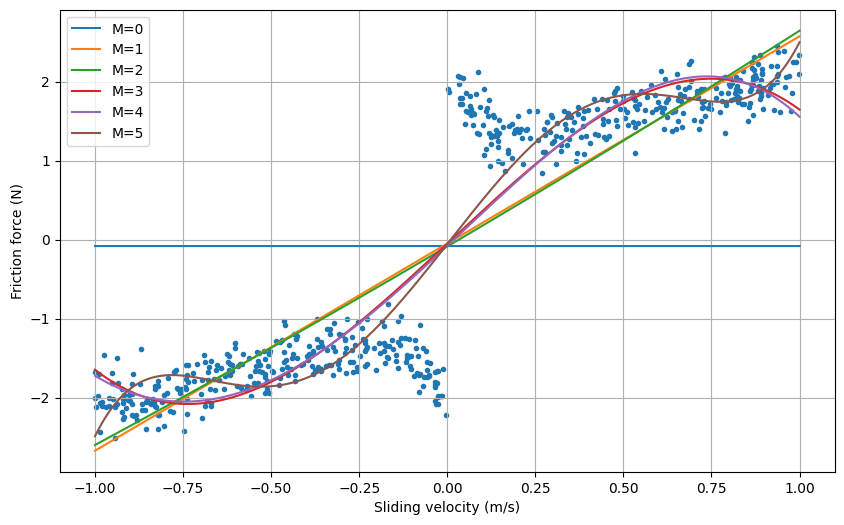

In [131]:
# Helper function
def predict_with_polynomial_features(x, w):
    M = w.shape[0] - 1
    phi = polynomial_feature_matrix(x, M)
    return predict_from_features(phi, w)

Ms = np.arange(6)
w_poly = [] # Stores the values of the weights for plotting later
for M in Ms:
    # Run the linear regression for each M, and store the resulting weights
    phi = polynomial_feature_matrix(X_train, M)
    w_poly.append(linear_regression(phi, Y_train))

# Plotting
plt.scatter(X_train, Y_train, marker='.')
for k in range(Ms.shape[0]):
    plt.plot(X_plot, predict_with_polynomial_features(X_plot, w_poly[k]), label=f'M={Ms[k]}')
plt.legend()
plt.xlabel('Sliding velocity (m/s)')
plt.ylabel('Friction force (N)')
plt.grid(True)

We observe a very specific pattern: the fitted polynomials of order $2k+1$ seem to be equal to the fitted polynomials of order $2(k+1)$.
Polynomials of degree even seem to not be useful in the prediction!
We verify that by plotting the weights of each degree:

(-0.5, 6.5)

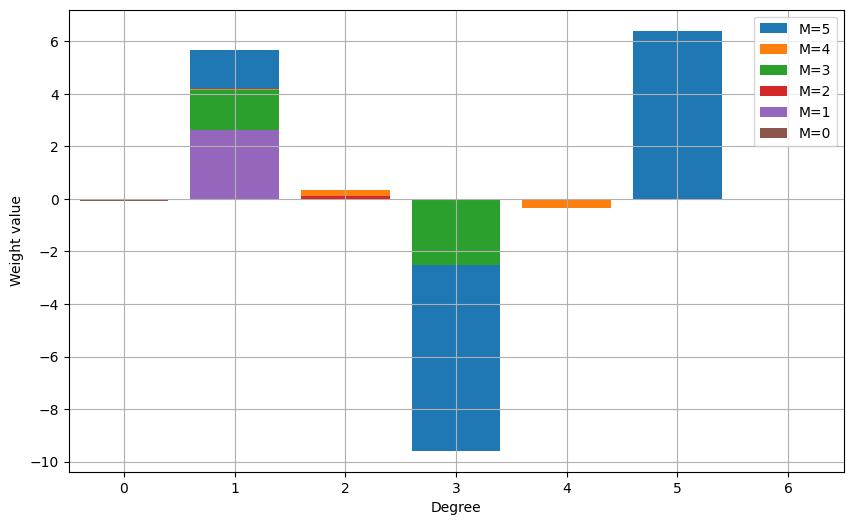

In [132]:
for k in range(len(w_poly)-1, -1, -1):
    plt.bar(np.arange(len(w_poly[k])),w_poly[k], label=f'M={Ms[k]}')
plt.legend()
plt.xlabel('Degree')
plt.ylabel('Weight value')
plt.grid()
plt.xlim(-0.5, len(w_poly) + 0.5)

This observation makes a lot of sense: according to the data distribution, the true function seems to be odd. Therefore, the monomials of even degree cannot capture true variations of the data, and can only lead to overfitting.

We decide to remove them from our feature matrix.

#### Question 4

Fill in the function ``odd_polynomial_feature_matrix`` , that outputs the feature matrix only with odd powers of the input value.

In [133]:
def odd_polynomial_feature_matrix(X: np.ndarray, M: int) -> np.ndarray:
    """ Computes the matrix \Phi with odd polynomial features up to degree M.
    Args:
        X: np.ndarray of shape (N,)
    Returns:
        phi: the feature matrix, of shape (N, K), where K = M / 2 or (M + 1) / 2 depending on the parity of M.
    
        1 x1 x1^3 x1^5 ... 
        .
        .
        .
        1 xN^1 xN^3 ...
    """
    return np.vstack([X**k for k in range(1, M+1, 2)]).T


We once again plot the outcome of the regression for various maximum degrees of the polynomial:

Solved: [2.62554719]
Solved: [ 4.16792228 -2.52542171]
Solved: [ 5.69191601 -9.61107581  6.41467307]
Solved: [  7.56331698 -26.15460815  42.28513768 -22.0475683 ]


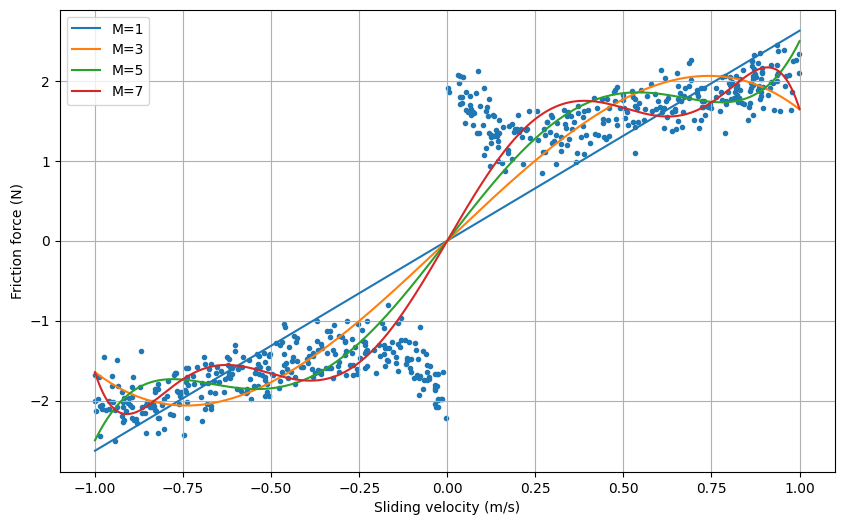

In [135]:
# Helper function
def predict_with_odd_polynomial_features(x, w):
    M = w.shape[0]*2 - 1
    phi = odd_polynomial_feature_matrix(x, M)
    return predict_from_features(phi, w)

Ms = np.arange(1, 8, 2)
w_poly = []
for M in Ms:
    phi = odd_polynomial_feature_matrix(X_train, M)
    w_poly.append(linear_regression(phi, Y_train))

# Plotting
plt.scatter(X_train, Y_train, marker='.')
for k in range(Ms.shape[0]):
    plt.plot(X_plot, predict_with_odd_polynomial_features(X_plot, w_poly[k]), label=f'M={Ms[k]}')
plt.legend()
plt.xlabel('Sliding velocity (m/s)')
plt.ylabel('Friction force (N)')
plt.grid(True)

### Model selection

The time has now come to select the "best" polynomial. Ideally, we would like to select the one that performs the best on unseen data. Therefore, we perform **model selection** on the validation data.

We start by training a large number of models with different values for the hyperparameter $M$:

In [136]:
Ms = np.arange(1, 30, 2)
w_poly = []

for M in Ms:
    phi = odd_polynomial_feature_matrix(X_train, M)
    w_poly.append(linear_regression(phi, Y_train))

Solved: [2.62554719]
Solved: [ 4.16792228 -2.52542171]
Solved: [ 5.69191601 -9.61107581  6.41467307]
Solved: [  7.56331698 -26.15460815  42.28513768 -22.0475683 ]
Solved: [   9.48404804  -54.15233862  150.59508471 -175.46910922   71.89757552]
Solved: [  11.55054811  -99.21642502  420.54890932 -828.74834335  758.91268951
 -261.36485887]
Solved: [   13.90307866  -171.30420252  1035.17958937 -3048.57857046
  4629.06752863 -3484.87031852  1028.95259446]
Solved: [ 1.59367531e+01 -2.55490599e+02  2.00878833e+03 -7.94772510e+03
  1.71875214e+04 -2.06346588e+04  1.29084282e+04 -3.28101057e+03]
Solved: [ 1.80245383e+01 -3.68188910e+02  3.69786662e+03 -1.91169965e+04
  5.60040196e+04 -9.67404430e+04  9.75778175e+04 -5.31278570e+04
  1.20580531e+04]
Solved: [ 2.02615362e+01 -5.17558390e+02  6.47199222e+03 -4.21956780e+04
  1.59377715e+05 -3.67832241e+05  5.26298935e+05 -4.55366294e+05
  2.18149809e+05 -4.44051070e+04]
Solved: [ 2.25934080e+01 -7.05098294e+02  1.07119901e+04 -8.57076589e+04
  4.03

We then evaluate each of these models on the validation data set, and select the one with the lowest validation error.

In [137]:
# YOUR CODE HER

# w_poly: List with |M| arrays containing the vector w
# Ms: Array of different hyper params

errors = []
w_poly = []

for m in Ms:
    ...
    phi = odd_polynomial_feature_matrix(X_val, m)
    w = linear_regression(phi, Y_val)
    
    y_pred = predict_from_features(phi, w)
    
    error = compute_error(y_pred, Y_val)
    print(error)

    errors.append(error)
    w_poly.append(w)


print("*"*20)
arg_M_star = np.argmin(errors)
M_star = Ms[arg_M_star]

print(arg_M_star)
print(M_star, errors[arg_M_star])


#### SOLUTION #####

# predictions = [predict_with_odd_polynomial_features(X_val, w) for w in w_poly]
# errors = [compute_error(y_pred, Y_val) for y_pred in predictions]
# errors = np.array(errors)

# arg_M_star = np.argmin(errors)
# M_star = Ms[arg_M_star]

# plt.plot(Ms, errors)
# plt.vlines(M_star, ymin=0, ymax=errors[arg_M_star], linestyle='dashed')
# plt.xlabel('Degree M')
# plt.ylabel('Validation error')
# plt.grid()
# plt.title('Validation loss of polynomial predictors')
# plt.ylim(0)

# print(f'Optimal value of M: {M_star}')



Solved: [2.6280039]
5.937479710758112
Solved: [ 4.04648674 -2.35183681]
5.434180347666751
Solved: [  5.72890193 -10.10930311   7.03368028]
5.153357682505784
Solved: [  7.9801484  -28.98616589  47.42655928 -24.79768419]
4.881918578889979
Solved: [   9.91009957  -56.29025364  153.01755162 -174.93094263   70.68983909]
4.731854025594883
Solved: [  11.97754304 -102.04307949  428.4345465  -843.47447983  775.55358508
 -268.7989446 ]
4.608586491209533
Solved: [   14.22756642  -172.90703024  1036.43736384 -3061.22000275
  4690.03903571 -3572.45486599  1068.45666751]
4.4930642251188715
Solved: [ 1.72824572e+01 -2.99786115e+02  2.48430773e+03 -1.02961811e+04
  2.32003777e+04 -2.88900827e+04  1.86771462e+04 -4.89179494e+03]
4.351530273922928
Solved: [ 2.04979563e+01 -4.66510148e+02  4.92265017e+03 -2.62972202e+04
  7.89570544e+04 -1.39141810e+05  1.42781713e+05 -7.89496070e+04
  1.81761584e+04]
4.206194972535961
Solved: [ 2.40503752e+01 -6.97585238e+02  9.22309892e+03 -6.23706921e+04
  2.42088483e

We can visualize the optimal model:

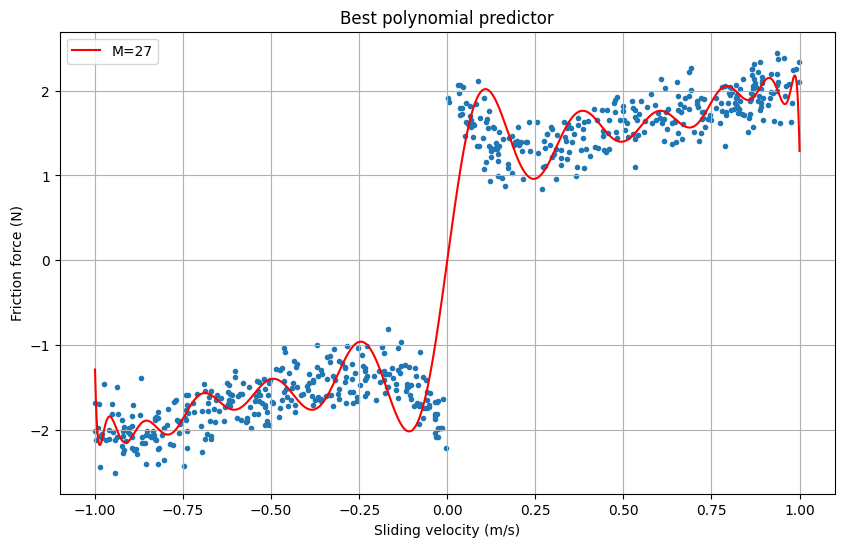

In [138]:
w_poly_star = w_poly[arg_M_star]

plt.scatter(X_train, Y_train, marker='.')
plt.plot(X_plot, predict_with_odd_polynomial_features(X_plot, w_poly_star), label=f'M={M_star}', color='r')
plt.legend()
plt.xlabel('Sliding velocity (m/s)')
plt.ylabel('Friction force (N)')
plt.grid(True)
_=plt.title('Best polynomial predictor')

The prediction fits nicely for most of the data, except near $0$.

Additionally, notice the sharp variation of the predicted curve on the boundary of the interval (near $\pm 1$). This is a clear sign of high variance and high values of the weights. We can confirm that by plotting the norm of $w$ for increasing values of $M$:

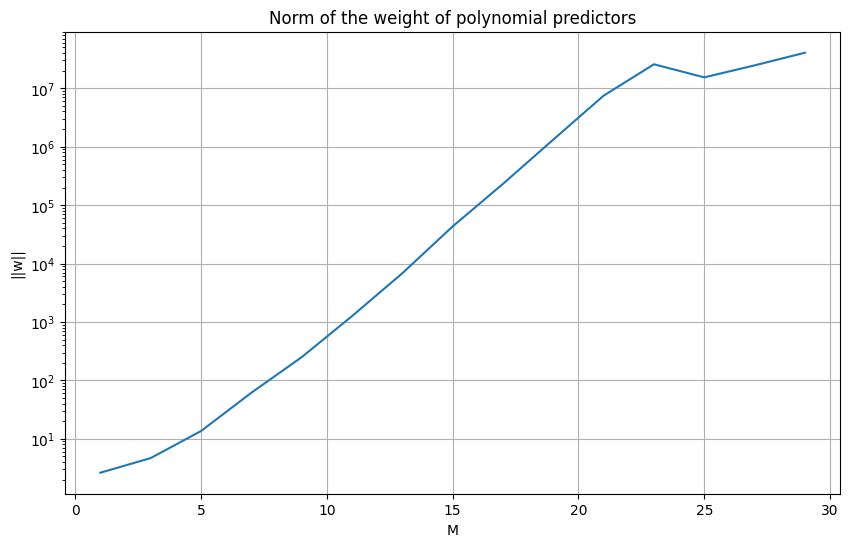

In [139]:
norms = [np.linalg.norm(w) for w in w_poly]
plt.semilogy(Ms, norms)
plt.grid()
plt.title('Norm of the weight of polynomial predictors')
plt.ylabel('||w||')
_=plt.xlabel('M')

The $y$-axis is logarithmic here: the magnitude of $\lVert w\rVert$ increases exponentially with $M$, and is about $10^8$ for the selected model!

This high value of the weights does not seem too bad on the area where we have data. Indeed, we have enough data points so that the predictions of the model are reasonable. However, the model has almost no extrapolation power, as we see it by plotting is on the slighlty larger interval $[-1.05, 1.05]$:

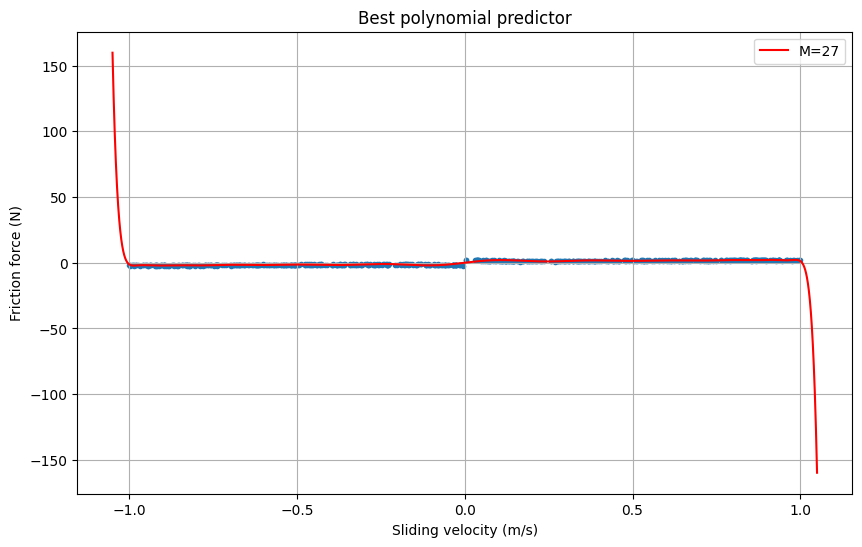

In [140]:
w_poly_star = w_poly[arg_M_star]
X_plot_wide = np.linspace(-1.05, 1.05, 5001, endpoint=True)
plt.scatter(X_train, Y_train, marker='.')
plt.plot(X_plot_wide, predict_with_odd_polynomial_features(X_plot_wide, w_poly_star), label=f'M={M_star}', color='r')
plt.legend()
plt.xlabel('Sliding velocity (m/s)')
plt.ylabel('Friction force (N)')
plt.grid(True)
_=plt.title('Best polynomial predictor')

The polynomial model therefore seems to lead to correct predictions within the range of the data, but has two problems:
1. The approximation at $v=0$ is rather poor;
2. It has very high variance, as illustrated by the high values of the weights and the disastrous extrapolation power.

This class of basis function is thererfore not adapted to represent the true data. Can we find a better hypothesis class?

## Part 2: Modelling a discontinuity

The data clearly shows a discontinuity of the true function at $v = 0$. Polynomials are continuous and are a terrible model for discontinuous functions. We can model this feature by incorporating the following function in our basis functions:
$$h:v \mapsto \begin{cases}1,&\text{if}~v \geq 0,\\ -1,&\text{otherwise}.\end{cases}$$

#### Question 5

Fill the function `discontinuous_polynomial_feature_matrix`, which adds the feature $h(x)$ to the odd polynomial features of `odd_polynomial_feature_matrix`.

In [141]:
def discontinuous_polynomial_feature_matrix(X: np.ndarray, M: int) -> np.ndarray:
    # Solution
    discontinuity = np.sign(X)
    poly = np.vstack([X**k for k in range(1, M+1, 2)])
    return np.vstack((discontinuity, poly)).T

We can reimplement our whole pipeline with this new feature matrix:

Solved: [1.34784931 0.63688338]
Solved: [ 1.50980611 -0.1107357   0.8328629 ]
Solved: [ 1.6583131  -1.17872221  4.17195799 -2.72385126]
Solved: [  1.75335003  -2.08996061   9.53652993 -13.16659904   6.09666954]
Solved: [  1.85645739  -3.31240956  21.1798332  -53.35045352  60.05326653
 -24.50995181]
Solved: [   1.93179061   -4.36256946   35.81388549 -130.97859743  237.44062339
 -204.91904991   67.14569475]
Solved: [   1.96546539   -4.8991745    46.11057599 -208.31468929  500.61411777
 -648.14615728  428.04810724 -113.37319435]
Solved: [ 2.00325510e+00 -5.57671458e+00  6.33733000e+01 -3.83521463e+02
  1.33017875e+03 -2.70118759e+03  3.16834947e+03 -1.98140088e+03
  5.09867345e+02]
Solved: [ 2.03303208e+00 -6.17510514e+00  8.31521979e+01 -6.44483238e+02
  2.95858947e+03 -8.17674810e+03  1.36782200e+04 -1.35015661e+04
  7.21810560e+03 -1.60910545e+03]
Solved: [ 2.06136721e+00 -6.80298222e+00  1.08846437e+02 -1.06537292e+03
  6.26425440e+03 -2.24997609e+04  5.04325614e+04 -7.07413532e+04
  

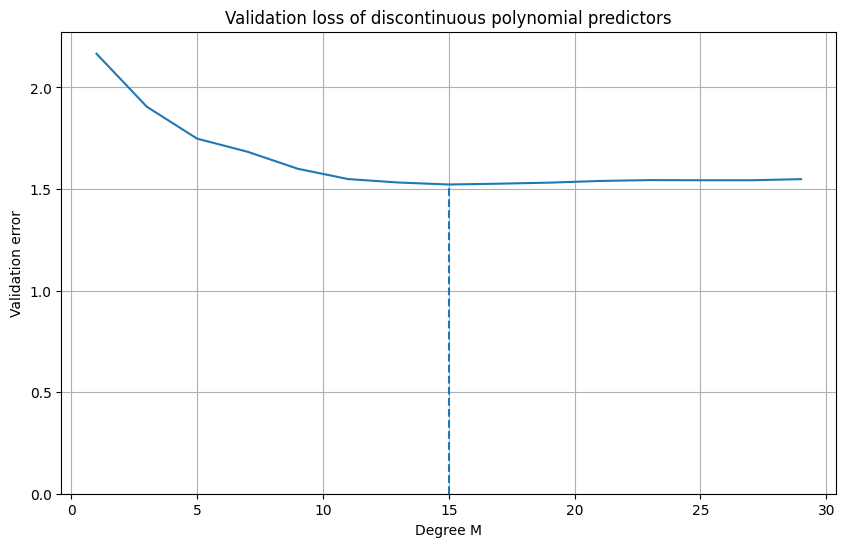

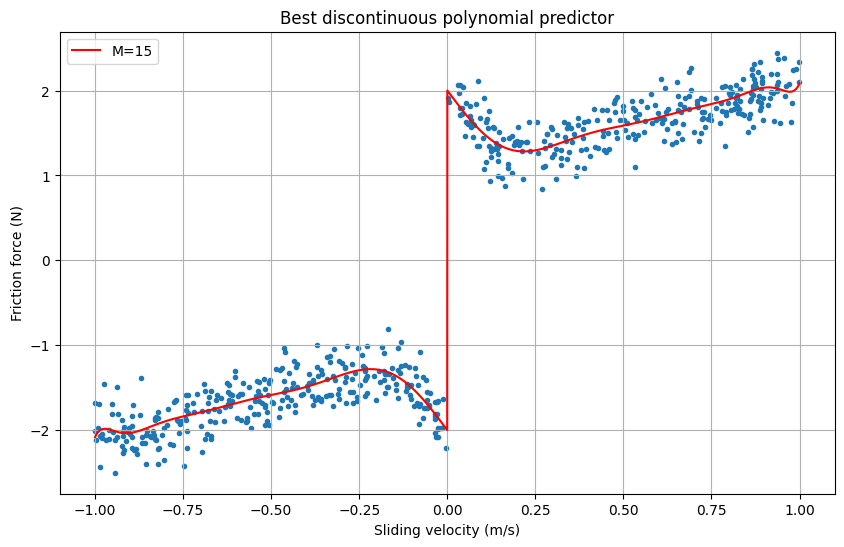

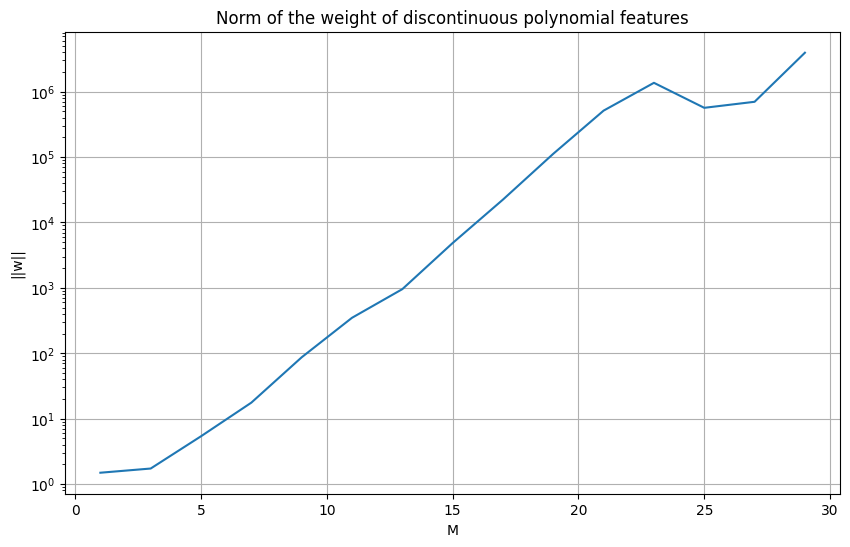

In [142]:
# Helper function
def predict_with_discontinuous_polynomial_features(x, w):
    M = (w.shape[0]-1)*2 - 1
    phi = discontinuous_polynomial_feature_matrix(x, M)
    return predict_from_features(phi, w)

def find_best_discontinuous_predictor():
    # Model training
    Ms = np.arange(1, 30, 2)
    w_disc = []
    for M in Ms:
        phi = discontinuous_polynomial_feature_matrix(X_train, M)
        w_disc.append(linear_regression(phi, Y_train))

    # Model selection
    predictions = [predict_with_discontinuous_polynomial_features(X_val, w) for w in w_disc]
    errors = [compute_error(y_pred, Y_val) for y_pred in predictions]
    errors = np.array(errors)

    arg_M_disc = np.argmin(errors)
    M_disc = Ms[arg_M_disc]

    plt.plot(Ms, errors)
    plt.vlines(M_disc, ymin=0, ymax=errors[arg_M_disc], linestyle='dashed')
    plt.xlabel('Degree M')
    plt.ylabel('Validation error')
    plt.grid()
    _=plt.ylim(0)
    plt.title(f'Validation loss of discontinuous polynomial predictors')

    w_disc_star = w_disc[arg_M_disc]

    plt.figure()
    plt.scatter(X_train, Y_train, marker='.')
    plt.plot(X_plot, predict_with_discontinuous_polynomial_features(X_plot, w_disc_star), label=f'M={M_disc}', color='r')
    plt.legend()
    plt.xlabel('Sliding velocity (m/s)')
    plt.ylabel('Friction force (N)')
    plt.grid(True)
    _=plt.title(f'Best discontinuous polynomial predictor')
    
    plt.figure()
    norms = [np.linalg.norm(w) for w in w_disc]
    plt.semilogy(Ms, norms)
    plt.grid()
    plt.title(f'Norm of the weight of discontinuous polynomial features')
    plt.ylabel('||w||')
    _=plt.xlabel('M')
    
    return w_disc, arg_M_disc, M_disc

w_disc, arg_M_disc, M_disc = find_best_discontinuous_predictor()
print(f'Degree of best predictor: {M_disc}')

We immediately notice three points:
1. The validation error is significantly lower for the best discontinuous predictor than for the best polynomial predictor
2. The prediction near $v = 0$ looks far more accurate than without the discontinuous feature
3. The weights are still very large. 

The first two points indicate that our model is a much better fit of the true function than the previous one; this feature is very useful. However, the model still has poor extrapolation power:


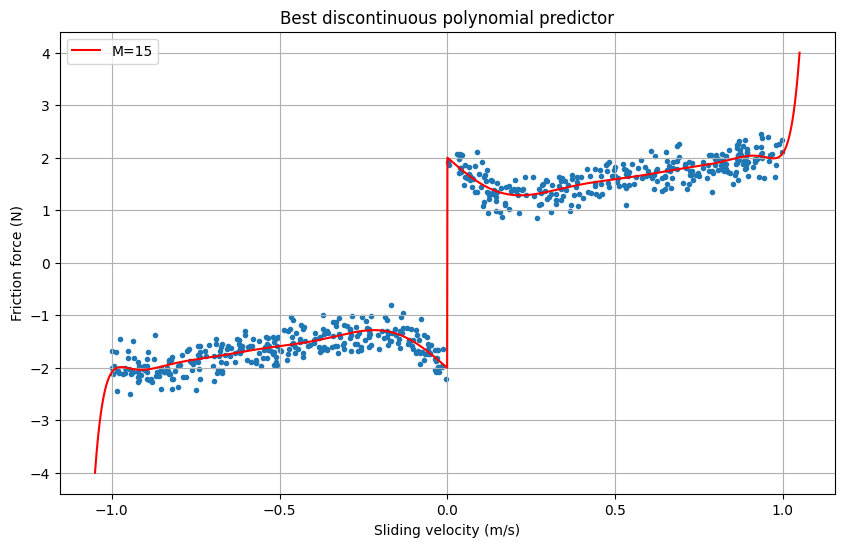

In [144]:
w_disc_star = w_disc[arg_M_disc]
plt.scatter(X_train, Y_train, marker='.')
plt.plot(X_plot_wide, predict_with_discontinuous_polynomial_features(X_plot_wide, w_disc_star), label=f'M={M_disc}', color='r')
plt.legend()
plt.xlabel('Sliding velocity (m/s)')
plt.ylabel('Friction force (N)')
plt.grid(True)
_=plt.title('Best discontinuous polynomial predictor')

This point will be improved with regularization; which we do while after adding another feature.

## Part 4: Regularization

The very high values of the weights are unsettling. This indicates that the model performs badly as soon as we get away from the training data.
We use regularization to identify meaningful features, and only keep these relevant features in the final model.

### One Last Feature: Modeling Discontinuous Derivatives

It seems that the function has a discontinuous derivative near $\pm 0.15$, symetrically around the origin. We can add the following basis function to take this into account: $$\begin{aligned}h_\mathrm{deriv}(x) &= \begin{cases}0,&\text{if }x\in[-0.15, 0.15],\\ x,&\text{otherwise}\end{cases} \\&= \mathrm{relu}(x - 0.15) - \mathrm{relu}(-0.15-x).\end{aligned}$$

In [145]:
def symrelu_feature_matrix(X: np.ndarray, M: int) -> np.ndarray:
    """ Computes the matrix \Phi with odd polynomial features up to degree M.
    Args:
        X: np.ndarray of shape (N,)
    Returns:
        phi: the feature matrix, of shape (N, K+2), K is the number of columns of the output of odd_polynomial_feature_matrix.
    """

    # def sym_relu(X: np.ndarray):
    #     vector = [0 if -0.15 <= i <= 0.15 else i for i in X]
    #     return np.array(vector)

    
    # sign = np.sign(X)
    # custom_relu = sym_relu(X)
    # poly = np.vstack([np.power(X, m) for m in range(1, M+1, 2)])

    # return np.vstack((sign, custom_relu, poly)).T


    # solution
    
    def relu(z):
        return z * (z>=0).astype(float)
    discontinuity = np.sign(X)
    symrelu = -relu(-0.15-X) + relu(X - 0.15)
    poly = np.vstack([X**k for k in range(1, M+1, 2)])
    out = np.vstack((discontinuity, symrelu, poly)).T
    return out

# Helper function
def predict_with_symrelu_polynomial_features(x, w):
    M = (w.shape[0]-2)*2 - 1
    phi = symrelu_feature_matrix(x, M)
    return predict_from_features(phi, w)

### Feature Selection with Regularization

Equipped with this new feature, we find the best regularized regressor with $M=29$:

Solved: [ 1.99160507  5.15633508 -4.84675736  2.77451845 -4.36717003 -0.5101375
  3.41430436  2.70362211  0.06274252 -1.90887703 -2.39246026 -1.67870311
 -0.42623593  0.73047312  1.31988365  1.04781075 -0.23491937]
Solved: [ 1.99013579e+00  5.34337842e+00 -4.83747543e+00  1.70106504e+00
 -2.30776251e+00 -3.72703541e-01  1.34532896e+00  1.40632354e+00
  5.84433387e-01 -3.20634822e-01 -9.18203941e-01 -1.11490821e+00
 -9.61259945e-01 -5.55892176e-01  8.30773569e-04  6.24774823e-01
  1.25214445e+00]
Solved: [ 1.96085271  5.11652603 -4.54180945  0.93540221 -0.73597703 -0.22125104
  0.31021085  0.3926806   0.20085523 -0.05673344 -0.25890815 -0.35724484
 -0.34502068 -0.23503194 -0.04700782  0.19868111  0.48377124]
Solved: [ 1.79111266e+00  2.99711017e+00 -2.84944053e+00  1.16744396e+00
 -1.02681354e-01 -3.06591681e-01 -1.98462183e-01 -8.77923717e-02
 -2.64987383e-02 -2.52946542e-03  2.47092704e-03  1.30489006e-03
  1.05269896e-03  4.93171124e-03  1.39179046e-02  2.78171763e-02
  4.59001870e-0

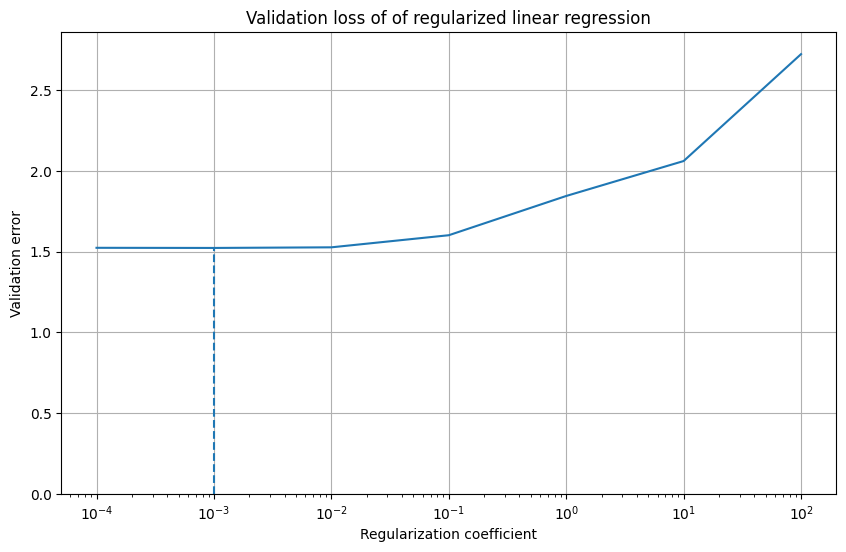

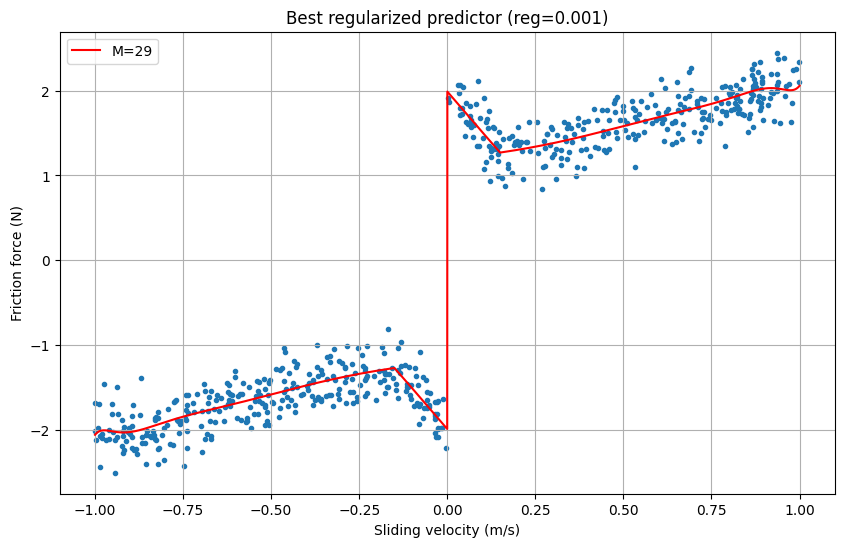

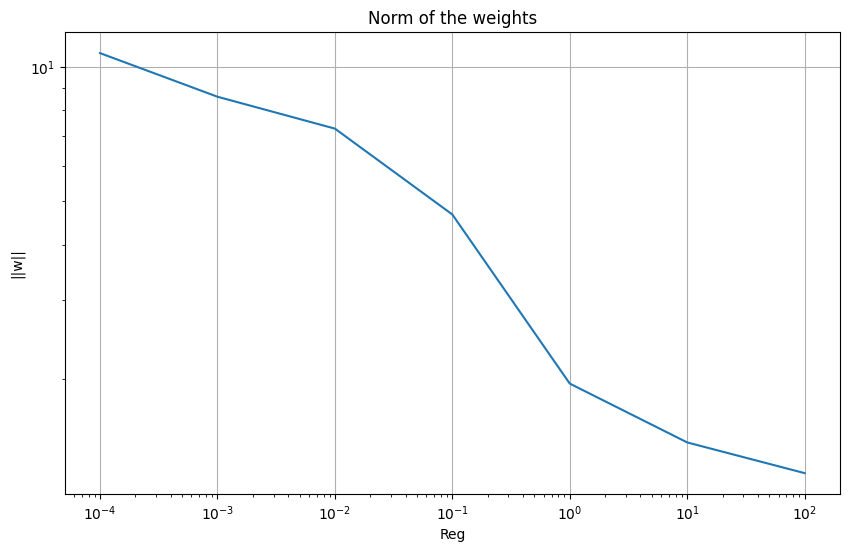

In [149]:
def find_best_regularizer(regularizers, M):
    # Model training
    w_reg = []
    for reg in regularizers:
        phi = symrelu_feature_matrix(X_train, M)
        w_reg.append(linear_regression(phi, Y_train, reg))

    # Model selection
    predictions = [predict_with_symrelu_polynomial_features(X_val, w) for w in w_reg]
    errors = [compute_error(y_pred, Y_val) for y_pred in predictions]
    errors = np.array(errors)

    arg_reg_best = np.argmin(errors)
    reg_best = regularizers[arg_reg_best]

    plt.semilogx(regularizers, errors)
    plt.vlines(reg_best, ymin=0, ymax=errors[arg_reg_best], linestyle='dashed')
    plt.xlabel('Regularization coefficient')
    plt.ylabel('Validation error')
    plt.grid()
    _=plt.ylim(0)
    plt.title(f'Validation loss of of regularized linear regression')

    w_reg_best = w_reg[arg_reg_best]

    plt.figure()
    plt.scatter(X_train, Y_train, marker='.')
    plt.plot(X_plot, predict_with_symrelu_polynomial_features(X_plot, w_reg_best), label=f'M={M}', color='r')
    plt.legend()
    plt.xlabel('Sliding velocity (m/s)')
    plt.ylabel('Friction force (N)')
    plt.grid(True)
    _=plt.title(f'Best regularized predictor (reg={reg_best})')
    
    plt.figure()
    norms = [np.linalg.norm(w) for w in w_reg]
    plt.loglog(regularizers, norms)
    plt.grid()
    plt.title(f'Norm of the weights')
    plt.ylabel('||w||')
    _=plt.xlabel('Reg')
    
    return w_reg_best, arg_reg_best, reg_best

M = 29
regularizers = np.array([10**k for k in range(-4, 3)])
w_reg_best, arg_reg_best, reg_best = find_best_regularizer(regularizers, M)


The validation loss has the same order of magnitude for $\mathrm{reg} \leq 0.1$ than for the unregularized regressor, but we observe the following:
1. The magnitude of the weights decreases sharply (from $10^4$ to less than $10$)
2. The learned function looks a lot like the ground truth! (no wiggles)
3. For $\mathrm{reg}\geq 1$, the validation loss increases: it seems that penalization gets too high.

Let's plot the best model on a larger interval:

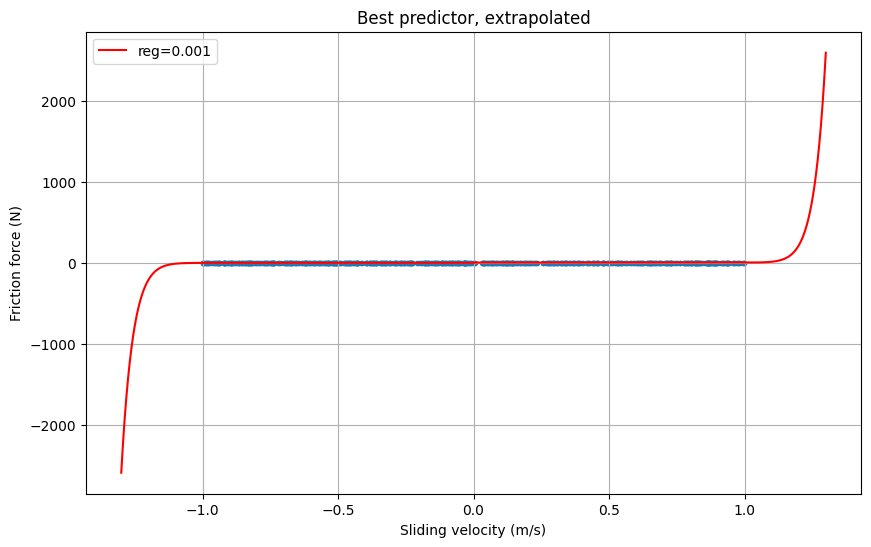

In [148]:
plt.scatter(X_train, Y_train, marker='.')
X_plot_wide = np.linspace(-1.3, 1.3, 5001, endpoint=True)
plt.plot(X_plot_wide, predict_with_symrelu_polynomial_features(X_plot_wide, w_reg_best), label=f'reg={reg_best}', color='r')
plt.legend()
plt.xlabel('Sliding velocity (m/s)')
plt.ylabel('Friction force (N)')
plt.grid(True)
_=plt.title('Best predictor, extrapolated')

The model is still very bad at extrapolating. It seems that the features useful for _interpolation_ get overpowered by others when _extrapolating_. Let's have a look at which features are considered useful, both for the unregularized and the regularized models:

Solved: [ 2.03091194e+00  6.45175336e+00 -5.79146541e+00  5.15036436e+01
 -1.30334007e+03  1.41544269e+04 -8.23329406e+04  2.76615024e+05
 -5.22543796e+05  4.09995024e+05  3.16480052e+05 -8.66113817e+05
  1.64633862e+05  1.17041276e+06 -1.51368533e+06  7.92748415e+05
 -1.59111547e+05]


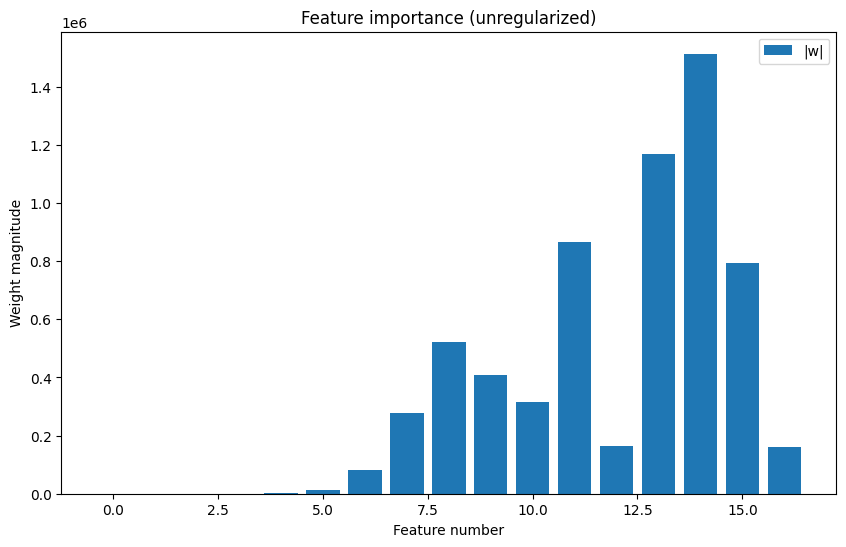

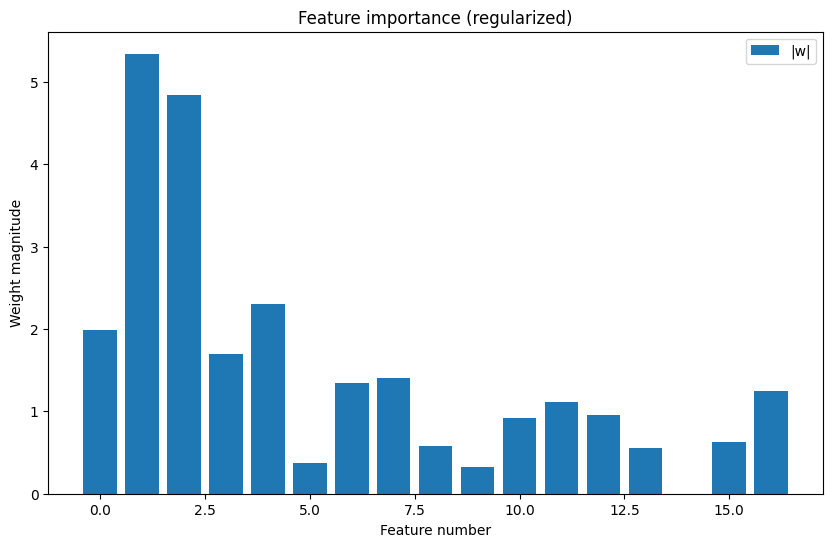

In [150]:
# from solution

plt.figure()
phi_unreg = symrelu_feature_matrix(X_train, M=29)
w_unreg = linear_regression(phi_unreg, Y_train)
plt.bar(np.arange(w_unreg.shape[0]), np.abs(w_unreg), label='|w|')
plt.xlabel('Feature number')
plt.ylabel('Weight magnitude')
plt.legend(loc='best')
_=plt.title('Feature importance (unregularized)')

plt.figure()
plt.bar(np.arange(w_reg_best.shape[0]), np.abs(w_reg_best), label='|w|')
plt.xlabel('Feature number')
plt.ylabel('Weight magnitude')
plt.legend(loc='best')
_=plt.title('Feature importance (regularized)')

The polynomial features of degree $>1$ are used very little for prediction! 
Regularization thus acts as a way to select features.
However, the weight of unused features remains non-zero and, therefore, they overpower lower degrees far from the origin.
This is a common behaviour of Ridge regression: it does not decrease weights all the way to $0$.

In contrast, let's just keep the features identified through Ridge regression:

Solved: [ 2.00812569  6.12236218 -5.11640129]


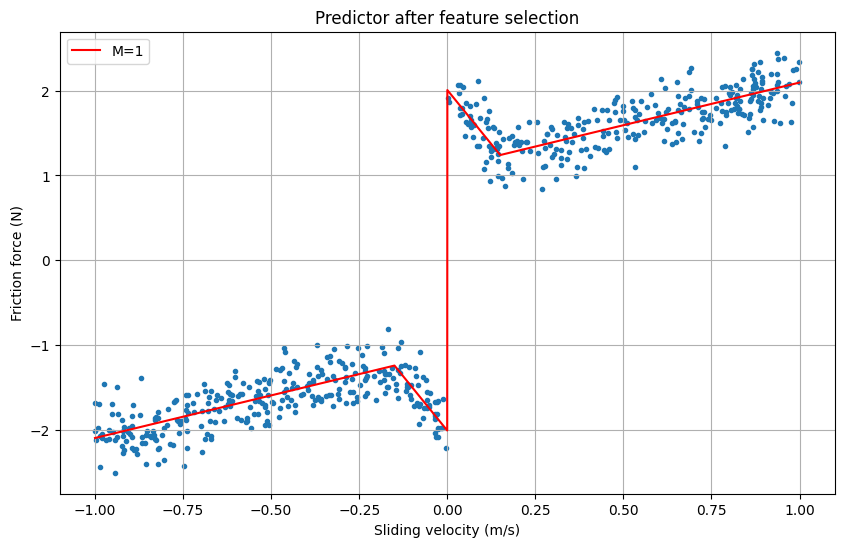

In [151]:
# from solution

phi = symrelu_feature_matrix(X_train, M=1)
w_best = linear_regression(phi, Y_train)

plt.figure()
plt.scatter(X_train, Y_train, marker='.')
plt.plot(X_plot, predict_with_symrelu_polynomial_features(X_plot, w_best), label=f'M={1}', color='r')
plt.legend()
plt.xlabel('Sliding velocity (m/s)')
plt.ylabel('Friction force (N)')
plt.grid(True)
_=plt.title(f'Predictor after feature selection')

## Part 5: Evaluation on test data

We now evaluate our model on the test data to have an idea of its generalization power.

After we have evaluated on the test data, **no more optimization is allowed** (e.g., tuning of hyperparameters and model selection)
Otherwise, we would be indirectly optimizing over the test loss.

The average RMS error is 0.2829. We can expect a prediction close to the true function up to this average error on unseen data.


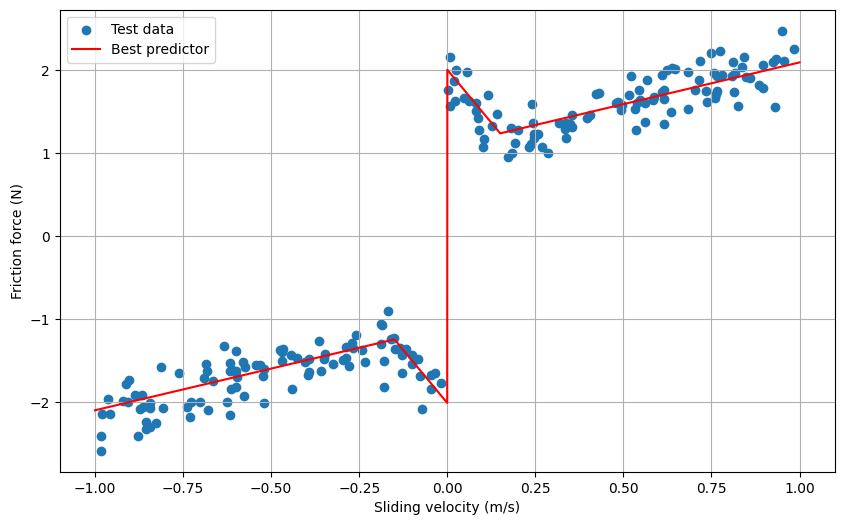

In [152]:
# from solutions

y_pred = predict_with_discontinuous_polynomial_features(X_test, w_best)
error = compute_error(y_pred, Y_test)
average_rms_error = np.sqrt(error / X_test.shape[0])

plt.scatter(X_test, Y_test, label='Test data')
plt.plot(X_plot, predict_with_symrelu_polynomial_features(X_plot, w_best), label='Best predictor', color='r')
plt.legend()
plt.grid()
plt.xlabel('Sliding velocity (m/s)')
plt.ylabel('Friction force (N)')

print(f'The average RMS error is {average_rms_error:.4f}. We can expect a prediction '
      'close to the true function up to this average error on unseen data.')